#### Custom Simple NN for handwritten digit recognition

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
from sklearn.metrics import log_loss, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from utils import cm_ratios

np.set_printoptions(suppress=True)

In [2]:
from keras.datasets import mnist
(X_train_og, Y_train_og), (X_test_og, Y_test_og) = mnist.load_data()

[]

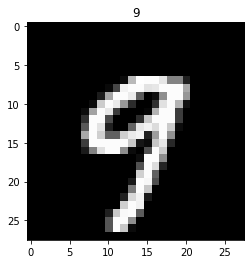

In [3]:
plt.figure()
plt.imshow(X_train_og[45], cmap=plt.cm.gray)
plt.title(Y_train_og[45])
plt.plot()

[]

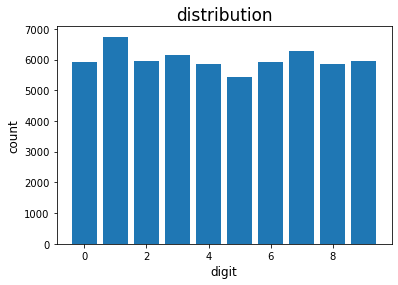

In [4]:
stats = {key:Y_train_og.tolist().count(key) for key in range(10)}
plt.figure('digits distribution')
plt.bar(x=list(stats.keys()), height=list(stats.values()))
plt.title('distribution', fontsize=17)
plt.xlabel('digit', fontsize=12)
plt.ylabel('count', fontsize=12)
plt.plot()
# evenly distributed dataset

In [5]:
# normalize data
X_train = X_train_og / 255
X_test = X_test_og / 255
# reshape data in order to feed into NN
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)

In [6]:
# OneHotEncoding the target variables in order to be able to use them in calculating cross entropy loss
OHE = OneHotEncoder(sparse=False)
Y_train = OHE.fit_transform(Y_train_og.reshape(60000,1))
Y_test = OHE.fit_transform(Y_test_og.reshape(10000,1))

In [7]:
# 3 layer network
# input layer = 28 x 28 (784)
# dense layer1 = 200 relu
# dense layer2 = 300 relu
# output dense layer = 10 softmax

In [8]:
class shit_NN:
    """
        X : training data of shape (f,m), where f = n_features, m = n_examples
        Y : labels of shape (c,m), where c = n_classes, m = n_examples
    """
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.m = X.shape[1]
        self.weights = {}
        self.biases = {}
        
        # layer 2
        self.weights['W1'] = np.random.randn(200,784)
        self.biases['b1'] = np.random.randn(200,1)
        # layer 3
        self.weights['W2'] = np.random.randn(300,200)
        self.biases['b2'] = np.random.randn(300,1)
        # layer 4
        self.weights['W3'] = np.random.randn(10,300)
        self.biases['b3'] = np.random.randn(10,1)
   
    # ACTIVATION FUNCTIONS
    def relu(self, Z):
        return np.maximum(Z, 0)
            
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
        
        
    def tanh(self, Z):
        return np.tanh(Z)
                
        
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=0))
        return expZ / np.sum(expZ, axis=0)

                
    # COST FUNCTIONS
    
    def MSE(self, y_pred):
        return (sum((self.Y - y_pred)**2)) / y_pred.shape[1]
    
    def log_loss(self, y_pred):
        #return log_loss(self.Y, y_pred)
        return - np.sum(self.Y * np.log(y_pred)) / y_pred.shape[1]
    
    def MAE(self, y_pred):
         return np.sum(abs(self.Y - y_pred)) / y_pred.shape[1]

    
    
    def compile_nn(self, epochs, alpha, metrics='accuracy'):
        self.epochs = epochs
        self.alpha = alpha
        self.metrics = metrics
        
        
    def predict(self, data):
        result = self.predict_probs(data)
        
        return result.argmax(axis=1)
        
    
    def predict_probs(self, data):
        Z1 = np.dot(self.weights['W1'], data) + self.biases['b1']
        A1 = self.relu(Z1)

        Z2 = np.dot(self.weights['W2'], A1) + self.biases['b2']
        A2 = self.relu(Z2)

        Z3 = np.dot(self.weights['W3'], A2) + self.biases['b3']
        A3 = self.softmax(Z3)
        
        return A3.T
        
    def fit(self):
        
        for epoch in range(1, self.epochs+1):
        
            # forward prop
            Z1 = np.dot(self.weights['W1'], self.X) + self.biases['b1']
            A1 = self.relu(Z1)

            Z2 = np.dot(self.weights['W2'], A1) + self.biases['b2']
            A2 = self.relu(Z2)

            Z3 = np.dot(self.weights['W3'], A2) + self.biases['b3']
            A3 = self.softmax(Z3)

            # calculate loss
            if (epoch%10==0):
                loss = self.log_loss(A3 + 1e-8)          # adding 10^-8 to A3 to avoid divide by 0 error in np.log
                y_pred = np.argmax(A3, axis=0) == np.argmax(self.Y, axis=0) 
                accuracy = np.mean(y_pred) 
                print(f"epoch : {epoch}")
                print(f"loss : {loss.round(3)}, train_accuracy : {accuracy.round(3)}\n")

            # bakward prop
            dL_Z3 = A3 - self.Y

            dL_W3 = np.dot(dL_Z3, A2.T) / self.m                                   # layer 3
            dL_b3 = np.sum(dL_Z3, axis=1, keepdims=True) / self.m

            dA2_Z2 = np.greater(Z2, 0).astype(int)     # relu derivative
            dL_Z2 = np.dot(self.weights['W3'].T, dL_Z3) * dA2_Z2

            dL_W2 = np.dot(dL_Z2, A1.T) / self.m                                    # layer 2
            dL_b2 = np.sum(dL_Z2, axis=1, keepdims=True) / self.m
  
            dA1_Z1 = np.greater(Z1, 0).astype(int)     # relu derivative    
            dL_Z1 = np.dot(self.weights['W2'].T, dL_Z2) * dA1_Z1

            dL_W1 = np.dot(dL_Z1, self.X.T)/ self.m                                       # layer 1
            dL_b1 = np.sum(dL_Z1, axis=1, keepdims=True)/ self.m
            
            # update parameters
            self.weights['W1'] -= self.alpha * dL_W1
            self.weights['W2'] -= self.alpha * dL_W2
            self.weights['W3'] -= self.alpha * dL_W3
            
            self.biases['b1'] -= self.alpha * dL_b1
            self.biases['b2'] -= self.alpha * dL_b2
            self.biases['b3'] -= self.alpha * dL_b3
                           
    def accuracy_score(self, y_pred, Y_true):
        compare = y_pred == Y_true
        return np.mean(compare)

In [9]:
network = shit_NN(X_train.T, Y_train.T)

network.compile_nn(100, 0.02)

In [10]:
network.fit()

epoch : 10
loss : 6.643, train_accuracy : 0.631

epoch : 20
loss : 5.004, train_accuracy : 0.721

epoch : 30
loss : 4.291, train_accuracy : 0.759

epoch : 40
loss : 3.856, train_accuracy : 0.783

epoch : 50
loss : 3.542, train_accuracy : 0.8

epoch : 60
loss : 3.311, train_accuracy : 0.813

epoch : 70
loss : 3.135, train_accuracy : 0.822

epoch : 80
loss : 2.989, train_accuracy : 0.83

epoch : 90
loss : 2.866, train_accuracy : 0.836

epoch : 100
loss : 2.754, train_accuracy : 0.842



In [11]:
y_pred = network.predict(X_test.T)

In [12]:
network.accuracy_score(y_pred, Y_test_og)

0.8443

[]

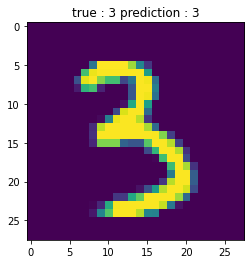

In [13]:
sample = 32
plt.imshow(X_test.T[:, sample].reshape((28,28)))
plt.title(f'true : {Y_test_og[sample]} prediction : {y_pred[sample]}')
plt.plot()
# lol

[]

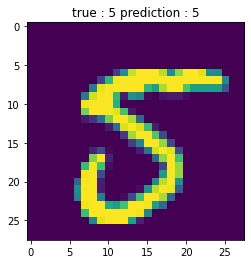

In [14]:
sample = 3321
plt.imshow(X_test.T[:, sample].reshape((28,28)))
plt.title(f'true : {Y_test_og[sample]} prediction : {y_pred[sample]}')
plt.plot()
# lol

In [15]:
stats = pd.DataFrame({'class':list(range(10)),
                      'pred_count':[y_pred.tolist().count(no) for no in range(10)],
                      'true_count':[Y_test_og.tolist().count(no) for no in range(10)],
                      'error':[Y_test_og.tolist().count(no) - y_pred.tolist().count(no) for no in range(10)]})

stats

,class,pred_count,true_count,error
0,0,998,980,-18
1,1,1126,1135,9
2,2,1045,1032,-13
3,3,1025,1010,-15
4,4,995,982,-13
5,5,898,892,-6
6,6,934,958,24
7,7,1014,1028,14
8,8,981,974,-7
9,9,984,1009,25


[]

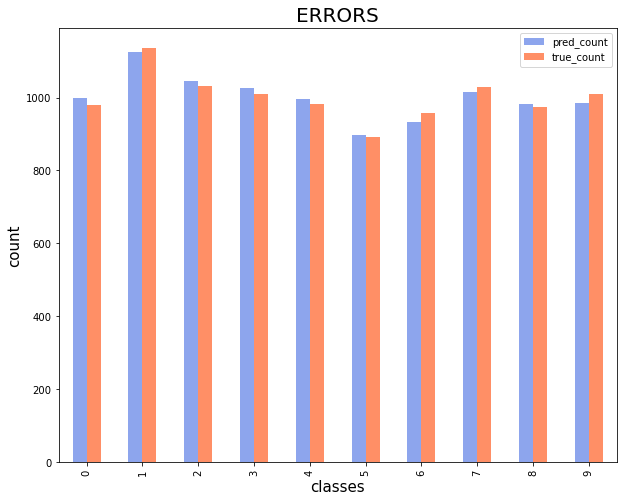

In [16]:
stats.iloc[:, 1:-1].plot(kind='bar',
                       alpha=0.6,
                       figsize=(10,8),
                       stacked=False,
                       color = ['royalblue', 'orangered'])
plt.xlabel('classes', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.title('ERRORS', fontsize=20)
plt.plot()

In [17]:
# 4 layer network
# input layer = 784 (28 x 28)
# dense layer1 = 200 relu
# dense layer2 = 250 relu
# dense layer3 = 300 relu
# output layer = 10 softmax

In [18]:
class shit_NN:
    """
        X : training data of shape (f,m), where f = n_features, m = n_examples
        Y : labels of shape (c,m), where c = n_classes, m = n_examples
    """
    
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        self.m = X.shape[1]
        self.weights = {}
        self.bias = {}
        
        # layer 2
        self.weights['W1'] = np.random.randn(200,784)
        self.bias['b1'] = np.random.randn(200,1)
        # layer 3
        self.weights['W2'] = np.random.randn(250,200)
        self.bias['b2'] = np.random.randn(250,1)
        # layer 4
        self.weights['W3'] = np.random.randn(300,250)
        self.bias['b3'] = np.random.randn(300,1)
        # layer 5
        self.weights['W4'] = np.random.randn(10,300)
        self.bias['b4'] = np.random.randn(10,1)
        
    # ACTIVATION FUNCTIONS
    def relu(self, Z):
        return np.maximum(Z, 0)
            
    
    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
        
        
    def tanh(self, Z):
        return np.tanh(Z)
                
        
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z, axis=0))
        return expZ / np.sum(expZ, axis=0)

                
    # COST FUNCTIONS
    
    def MSE(self, y_pred):
        return (sum((self.Y - y_pred)**2)) / y_pred.shape[1]
    
    def log_loss(self, y_pred):
        #return log_loss(self.Y, y_pred)
        return - np.sum(self.Y * np.log(y_pred)) / y_pred.shape[1]
    
    def MAE(self, y_pred):
         return np.sum(abs(self.Y - y_pred)) / y_pred.shape[1]

    
    
    def compile_nn(self, epochs, alpha, metrics='accuracy'):
        self.epochs = epochs
        self.alpha = alpha
        self.metrics = metrics
        
        
    def predict(self, data):
        result = self.predict_probs(data)
        
        return result.argmax(axis=1)
        
    
    def predict_probs(self, data):
        Z1 = np.dot(self.weights['W1'], data) + self.bias['b1']
        A1 = self.relu(Z1)

        Z2 = np.dot(self.weights['W2'], A1) + self.bias['b2']
        A2 = self.relu(Z2)

        Z3 = np.dot(self.weights['W3'], A2) + self.bias['b3']
        A3 = self.relu(Z3)
        
        Z4 = np.dot(self.weights['W4'], A3) + self.bias['b4']
        A4 = self.softmax(Z4)
        
        return A4.T
        
    def fit(self):
        
        for epoch in range(1, self.epochs+1):
        
            # forward prop
            Z1 = np.dot(self.weights['W1'], self.X) + self.bias['b1']
            A1 = self.relu(Z1)

            Z2 = np.dot(self.weights['W2'], A1) + self.bias['b2']
            A2 = self.relu(Z2)

            Z3 = np.dot(self.weights['W3'], A2) + self.bias['b3']
            A3 = self.relu(Z3)
            
            Z4 = np.dot(self.weights['W4'], A3) + self.bias['b4']
            A4 = self.softmax(Z4)

            # calculate loss
            if (epoch%10==0):
                loss = self.log_loss(A4 + 1e-8)          # adding 10^-8 to A3 to avoid divide by 0 error in np.log
                y_pred = np.argmax(A4, axis=0) == np.argmax(self.Y, axis=0) 
                accuracy = np.mean(y_pred) 
                print(f"epoch : {epoch}")
                print(f"loss : {loss.round(3)}, train_accuracy : {accuracy.round(3)}\n")

            # bakward prop
            dL_Z4 = A4 - self.Y
            
            dL_W4 = np.dot(dL_Z4, A3.T) / self.m                               # layer 4
            dL_b4 = np.sum(dL_Z4, axis=1, keepdims=True) / self.m
            
            dA3_Z3 = np.greater(Z3, 0).astype(int)     # relu derivative
            dL_Z3 = np.dot(self.weights['W4'].T, dL_Z4) * dA3_Z3 

            dL_W3 = np.dot(dL_Z3, A2.T) / self.m                               # layer 3                          
            dL_b3 = np.sum(dL_Z3, axis=1, keepdims=True) / self.m

            dA2_Z2 = np.greater(Z2, 0).astype(int)     # relu derivative
            dL_Z2 = np.dot(self.weights['W3'].T, dL_Z3) * dA2_Z2

            dL_W2 = np.dot(dL_Z2, A1.T) / self.m                                # layer 2
            dL_b2 = np.sum(dL_Z2, axis=1, keepdims=True) / self.m
  
            dA1_Z1 = np.greater(Z1, 0).astype(int)     # relu derivative    
            dL_Z1 = np.dot(self.weights['W2'].T, dL_Z2) * dA1_Z1

            dL_W1 = np.dot(dL_Z1, self.X.T)/ self.m                             # layer 1
            dL_b1 = np.sum(dL_Z1, axis=1, keepdims=True)/ self.m
            
            # update parameters
            self.weights['W1'] -= self.alpha * dL_W1
            self.weights['W2'] -= self.alpha * dL_W2
            self.weights['W3'] -= self.alpha * dL_W3
            self.weights['W4'] -= self.alpha * dL_W4
            
            self.bias['b1'] -= self.alpha * dL_b1
            self.bias['b2'] -= self.alpha * dL_b2
            self.bias['b3'] -= self.alpha * dL_b3
            self.bias['b4'] -= self.alpha * dL_b4
                           
    def accuracy_score(self, y_pred, Y_true):
        compare = y_pred == Y_true
        return np.mean(compare)

In [19]:
# CONFUSING MATH

# The softmax function makes it complicated and it is easier to analyse and calculate the derivatives when the
# the output layer is considered different from the last layer Z_n, and b/w that Z_n and output layer, softmax 
# is applied. The output of each neuron is dependent on all the outputs of 
# previous layer. Therefore there are multiple 'paths' from the Cost function to each weight and the derivatives
# through all that paths must averaged to find the derivative of J w.r.t a particular weight.

In [20]:
# AWESOME ARTICLES 
# https://medium.com/@zeeshanmulla/cost-activation-loss-function-neural-network-deep-learning-what-are-these-91167825a4de
# https://stackoverflow.com/questions/40575841/numpy-calculate-the-derivative-of-the-softmax-function
# https://stats.stackexchange.com/questions/235528/backpropagation-with-softmax-cross-entropy
# https://www.youtube.com/watch?v=5-rVLSc2XdE
# https://eli.thegreenplace.net/2016/the-softmax-function-and-its-derivative/
# http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/

In [21]:
network = shit_NN(X_train.T, Y_train.T)

network.compile_nn(100, 0.02)

In [22]:
# 4 layer network is not working :(
network.fit()

epoch : 10
loss : 16.351, train_accuracy : 0.112

epoch : 20
loss : 9.449, train_accuracy : 0.104

epoch : 30
loss : 7.467, train_accuracy : 0.104

epoch : 40
loss : 6.395, train_accuracy : 0.104

epoch : 50
loss : 4.946, train_accuracy : 0.104

epoch : 60
loss : 3.555, train_accuracy : 0.104

epoch : 70
loss : 2.717, train_accuracy : 0.104

epoch : 80
loss : 2.502, train_accuracy : 0.104

epoch : 90
loss : 2.459, train_accuracy : 0.104

epoch : 100
loss : 2.432, train_accuracy : 0.104



In [23]:
y_pred = network.predict(X_test.T)

In [24]:
network.accuracy_score(y_pred, Y_test_og)
# model is learning weights associated with only 1 (random) digit

0.1028

In [25]:
stats = pd.DataFrame({'class':list(range(10)),
                      'pred_count':[y_pred.tolist().count(no) for no in range(10)],
                      'true_count':[Y_test_og.tolist().count(no) for no in range(10)],
                      'error':[Y_test_og.tolist().count(no) - y_pred.tolist().count(no) for no in range(10)]})

stats

,class,pred_count,true_count,error
0,0,0,980,980
1,1,0,1135,1135
2,2,0,1032,1032
3,3,0,1010,1010
4,4,0,982,982
5,5,0,892,892
6,6,0,958,958
7,7,10000,1028,-8972
8,8,0,974,974
9,9,0,1009,1009


[]

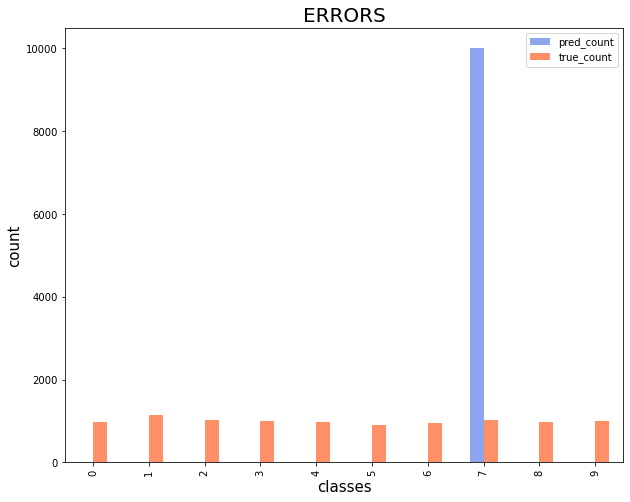

In [26]:
stats.iloc[:, 1:-1].plot(kind='bar',
                       alpha=0.6,
                       figsize=(10,8),
                       stacked=False,
                       color = ['royalblue', 'orangered'])
plt.xlabel('classes', fontsize=15)
plt.ylabel('count', fontsize=15)
plt.title('ERRORS', fontsize=20)
plt.plot()
# model learnt only digit 7.

### Using tensorflow

In [23]:
import tensorflow as tf

In [24]:
from keras.datasets import mnist
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [25]:
# Normalize the train dataset
X_train = tf.keras.utils.normalize(X_train, axis=1)
# Normalize the test dataset
X_test = tf.keras.utils.normalize(X_test, axis=1)

In [26]:
# Same network structure (input, 6, 10, 10)
#Build the model object
model = tf.keras.models.Sequential()
# Add the Flatten Layer
model.add(tf.keras.layers.Flatten())
# Build the input and the hidden layers
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(200, activation=tf.nn.relu))
# Build the output layer
model.add(tf.keras.layers.Dense(10, activation=tf.nn.softmax))

In [27]:
# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [28]:
model.fit(x=X_train, y=Y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2685 - accuracy: 0.9208
Epoch 2/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.1115 - accuracy: 0.9658
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0753 - accuracy: 0.9756
Epoch 4/5
1875/1875 [==============================] - 5s 2ms/step - loss: 0.0570 - accuracy: 0.9814
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.0421 - accuracy: 0.9869


In [29]:
# Evaluate the model performance
test_loss, test_acc = model.evaluate(x=X_test, y=Y_test)
# Print out the model accuracy 
print('\nTest accuracy:', test_acc)

313/313 [==============================] - 1s 2ms/step - loss: 0.0885 - accuracy: 0.9757

Test accuracy: 0.9757000207901001


In [31]:
# clearly, tflow is nothing compared to my implementation :P